In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Gradient - PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
nb_states = 1
nb_actions = 10

In [3]:
_theta_t = torch.zeros((nb_states, nb_actions), requires_grad=True)

In [4]:
def pi_t(state):
    """Return policy, i.e. probability distribution over actions."""
    with torch.no_grad():
        prob_t = torch.softmax(_theta_t[state], dim=-1)
        return prob_t.numpy()

In [5]:
def grad_t(state, action):
    prob_t = torch.softmax(_theta_t[state], dim=-1)
    log_t = torch.log(prob_t)
    loss = log_t[action]  # -1 grad ascent, scale by R
    loss.backward()
    
    grad = _theta_t.grad.data.numpy().copy()
    _theta_t.grad.data.zero_()
    return grad

In [6]:
pi_t(0)

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)

In [7]:
grad_t(0, 0)

array([[ 0.90000004, -0.1       , -0.1       , -0.1       , -0.1       ,
        -0.1       , -0.1       , -0.1       , -0.1       , -0.1       ]],
      dtype=float32)

# Gaussian - PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

In [2]:
def gaussian_t(x_t, mean_t, std_t):
    var_t = std_t**2
    denom_t = (2*np.pi*var_t)**.5
    num_t = torch.exp( -(x_t-mean_t)**2 / (2*var_t) )
    return num_t / denom_t

In [3]:
def pi_t(state, mu_t, sigma_t, do_exp):
    with torch.no_grad():
        std_t = torch.exp(sigma_t) if do_exp else sigma_t
        #return np.random.normal(loc=theta_mu, scale=theta_sigma)
        return torch.normal(mu_t, std_t).item()

In [4]:
_theta_mu_t = torch.tensor([0.0], requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], requires_grad=True)

In [5]:
X = np.linspace(-3, 3)
grad_X = []
grad_Y = []
for a in X:
    std_t = torch.exp(_theta_sigma_t)
    prob_t = gaussian_t(a, _theta_mu_t, std_t)
    log_t = torch.log(prob_t)
    loss = log_t
    loss.backward()
    
    grad_X.append(_theta_mu_t.grad.data.item())
    _theta_mu_t.grad.data.zero_()
    grad_Y.append(_theta_sigma_t.grad.data.item())
    _theta_sigma_t.grad.data.zero_()

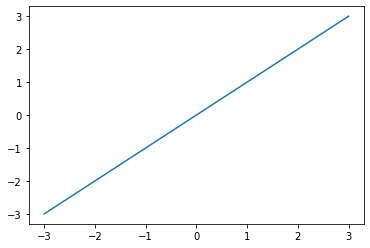

In [6]:
plt.plot(X, grad_X)

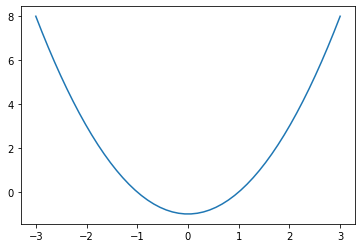

In [7]:
plt.plot(X, grad_Y)

In [8]:
# _dist = torch.distributions.Normal(_theta_mu_t, _theta_sigma_t)

In [37]:
def print_plot(mu_t, sigma_t, do_exp):
    
    with torch.no_grad():
        
        
        
        print('mu_t:', mu_t, mu_t.grad)
        print('sigma_t:', sigma_t, sigma_t.grad)
        
        std_t = torch.exp(sigma_t) if do_exp else sigma_t
            
        print('std_t:', std_t, std_t.grad)
        
        res = []
        for i in range(100000):
            res.append(pi_t(0, mu_t, sigma_t, do_exp))
        plt.hist(res, bins=100, density=True)
        
        X_t = torch.linspace(-10, 10, dtype=float)
        Y_t = gaussian_t(X_t, mean_t=0.0, std_t=1.0)
        plt.plot(X_t.numpy(), Y_t.numpy())
        Y_t = gaussian_t(X_t, mean_t=mu_t, std_t=std_t)
        plt.plot(X_t.numpy(), Y_t.numpy(), color='red')
        
    plt.show()

In [11]:
_theta_mu_t = torch.tensor([0.0], requires_grad=True)
_theta_sigma_t = torch.tensor([1.0], requires_grad=True)

mu_t: tensor([0.], requires_grad=True) None
sigma_t: tensor([1.], requires_grad=True) None
std_t: tensor([1.], requires_grad=True) None


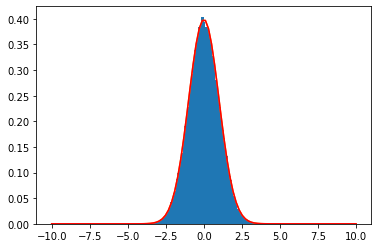

In [12]:
print_plot(_theta_mu_t, _theta_sigma_t, do_exp=False)

In [25]:
do_exp = True

In [26]:
_theta_mu_t = torch.tensor([0.0], dtype=float, requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], dtype=float, requires_grad=True)

In [27]:
lr = 0.01

In [28]:
std_t = torch.exp(_theta_sigma_t) if do_exp else _theta_sigma_t
std_t

tensor([1.], dtype=torch.float64, grad_fn=<ExpBackward>)

In [29]:
prob_t = gaussian_t(5.0, _theta_mu_t, std_t)
print(prob_t)
print(prob_t.grad)

tensor([1.4867e-06], dtype=torch.float64, grad_fn=<DivBackward0>)
None


In [30]:
log_t = torch.log(prob_t)
print(log_t)
print(log_t.grad)

tensor([-13.4189], dtype=torch.float64, grad_fn=<LogBackward>)
None


In [31]:
loss = log_t
loss.backward()

In [32]:
print(log_t)
print(log_t.grad)

tensor([-13.4189], dtype=torch.float64, grad_fn=<LogBackward>)
None


In [33]:
print(_theta_mu_t)
print(_theta_mu_t.grad)

tensor([0.], dtype=torch.float64, requires_grad=True)
tensor([5.], dtype=torch.float64)


In [34]:
print(_theta_sigma_t)
print(_theta_sigma_t.grad)

tensor([0.], dtype=torch.float64, requires_grad=True)
tensor([24.], dtype=torch.float64)


In [35]:
_theta_mu_t.data.add_(lr * _theta_mu_t.grad.data)
_theta_sigma_t.data.add_(lr * _theta_sigma_t.grad.data)
_theta_mu_t.grad.data.zero_()
_theta_sigma_t.grad.data.zero_()

tensor([0.], dtype=torch.float64)

mu_t: tensor([0.0500], dtype=torch.float64, requires_grad=True) tensor([0.], dtype=torch.float64)
sigma_t: tensor([0.2400], dtype=torch.float64, requires_grad=True) tensor([0.], dtype=torch.float64)
std_t: tensor([1.2712], dtype=torch.float64) None


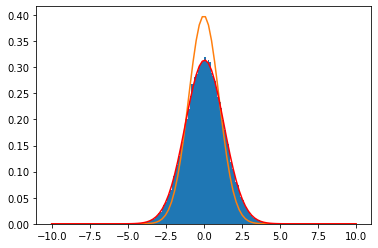

In [38]:
print_plot(_theta_mu_t, _theta_sigma_t, do_exp)

In [43]:
lr = 0.01

In [44]:
_theta_mu_t = torch.tensor([0.0], dtype=float, requires_grad=True)
_theta_sigma_t = torch.tensor([0.0], dtype=float, requires_grad=True)

In [45]:
res_theta_mu = []
res_grad_theta_mu = []
res_theta_sigma = []
res_grad_theta_sigma = []
res_sigma = []

In [46]:
for i in range(2000):
    std_t = torch.exp(_theta_sigma_t)
    prob_t = gaussian_t(5.0, _theta_mu_t, std_t)
    log_t = torch.log(prob_t)
    loss = log_t
    loss.backward()
        
    i_grad_theta_mu = _theta_mu_t.grad.data.item()
    i_grad_theta_sigma = _theta_sigma_t.grad.data.item()
    
    _theta_mu_t.data.add_(lr * _theta_mu_t.grad.data)
    _theta_sigma_t.data.add_(lr * _theta_sigma_t.grad.data)
    _theta_mu_t.grad.data.zero_()
    _theta_sigma_t.grad.data.zero_()
    
    with torch.no_grad():
        i_theta_mu = _theta_mu_t.item()
        i_theta_sigma = _theta_sigma_t.item()
        i_sigma = torch.exp(_theta_sigma_t).item()
    
    res_theta_mu.append(i_theta_mu)
    res_grad_theta_mu.append(i_grad_theta_mu)
    res_theta_sigma.append(i_theta_sigma)
    res_grad_theta_sigma.append(i_grad_theta_sigma)
    res_sigma.append(i_sigma)
    

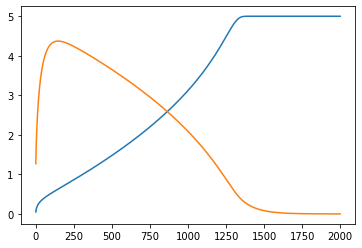

In [48]:
plt.plot(res_theta_mu)
plt.plot(res_sigma)

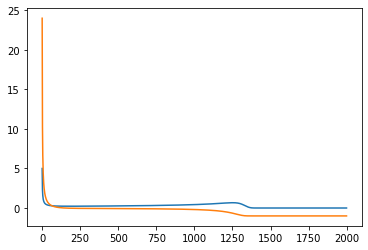

In [49]:
plt.plot(res_grad_theta_mu)
plt.plot(res_grad_theta_sigma)

# Grad - numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
theta_mu = 0.0
theta_sigma = 0.0

In [3]:
def gaussian(x, mean, std):
    var = std**2
    denom = (2*np.pi*var)**.5
    num = np.exp( -(x-mean)**2 / (2*var) )
    return num / denom

In [4]:
def pi(theta_mu, theta_sigma):
    return np.random.normal(loc=theta_mu, scale=np.exp(theta_sigma))

In [5]:
def x_mu(state):
    return 1.0

In [6]:
def x_sigma(state):
    return 1.0

In [7]:
def grad_ln_theta_mu(state, action, theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    return (1 / sigma**2) * (action - mu) * x_mu(state)  # Ex. 13.4

In [8]:
def grad_ln_theta_sigma(state, action, theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    return (((action - mu)**2 / sigma**2) - 1) * x_sigma(state)

In [9]:
grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)

5.0

In [10]:
grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)

24.0

In [11]:
aa = np.linspace(-3, 3)
mm = grad_ln_theta_mu(None, aa, theta_mu, theta_sigma)
ss = grad_ln_theta_sigma(None, aa, theta_mu, theta_sigma)

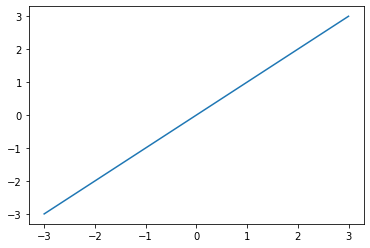

In [12]:
plt.plot(aa, mm)

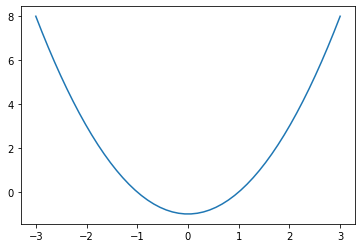

In [13]:
plt.plot(aa, ss)

In [14]:
def print_plot(theta_mu, theta_sigma):
    mu, sigma = theta_mu, np.exp(theta_sigma)
    
    print('mu:', mu)
    print('sigma:', sigma)
        
    res = []
    for i in range(100000):
        res.append(pi(theta_mu, theta_sigma))
    plt.hist(res, bins=100, density=True)

    X = np.linspace(-10, 10)
    Y = gaussian(X, mean=0.0, std=1.0)
    plt.plot(X, Y)
    Y = gaussian(X, mean=mu, std=sigma)
    plt.plot(X, Y, color='red')

    plt.show()

mu: 0.0
sigma: 1.0


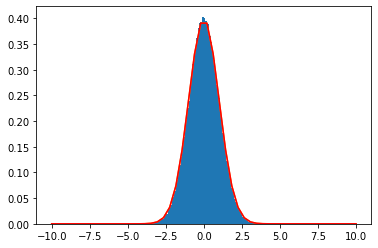

In [15]:
print_plot(theta_mu, theta_sigma)

In [16]:
theta_mu = 0.0
theta_sigma = 0.0

In [17]:
lr = 0.01

In [18]:
grad_theta_mu = grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)
grad_theta_sigma = grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)

In [19]:
print(theta_mu, grad_theta_mu)
print(theta_sigma, grad_theta_sigma)

0.0 5.0
0.0 24.0


In [20]:
theta_mu += lr * grad_theta_mu
theta_sigma += lr * grad_theta_sigma

mu: 0.05
sigma: 1.2712491503214047


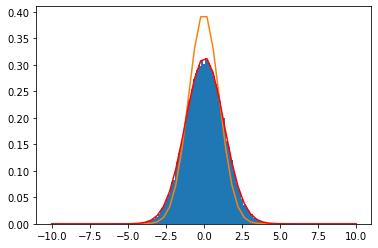

In [21]:
print_plot(theta_mu, theta_sigma)

In [22]:
lr = 0.01
theta_mu = 0.0
theta_sigma = 0.0

In [23]:
X = np.linspace(-3, 3)
grad_X = grad_ln_theta_mu(None, X, theta_mu, theta_sigma)
grad_Y = grad_ln_theta_sigma(None, X, theta_mu, theta_sigma)

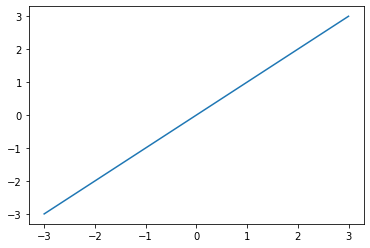

In [24]:
plt.plot(X, grad_X)

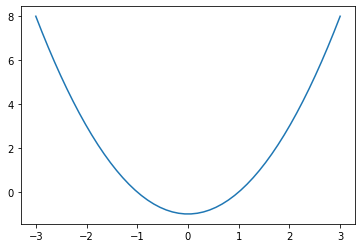

In [25]:
plt.plot(X, grad_Y)

In [26]:
lr = 0.01
theta_mu = 0.0
theta_sigma = 0.0

In [27]:
res_theta_mu = []
res_grad_theta_mu = []
res_theta_sigma = []
res_grad_theta_sigma = []
res_sigma = []

In [28]:
for i in range(2000):
    grad_theta_mu = grad_ln_theta_mu(None, 5.0, theta_mu, theta_sigma)
    grad_theta_sigma = grad_ln_theta_sigma(None, 5.0, theta_mu, theta_sigma)
    
    theta_mu += lr * grad_theta_mu
    theta_sigma += lr * grad_theta_sigma
    
    res_theta_mu.append(theta_mu)
    res_grad_theta_mu.append(grad_theta_mu)
    res_theta_sigma.append(theta_sigma)
    res_grad_theta_sigma.append(grad_theta_sigma)
    res_sigma.append(np.exp(theta_sigma))

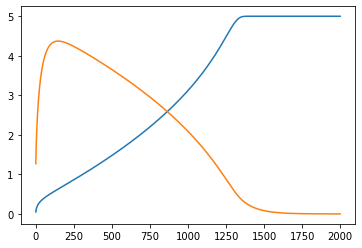

In [29]:
plt.plot(res_theta_mu)
plt.plot(res_sigma)

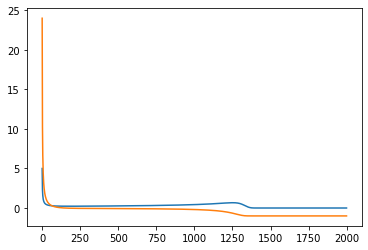

In [31]:
plt.plot(res_grad_theta_mu)
plt.plot(res_grad_theta_sigma)